# 조별과제
1. 2019년 제주도 서귀포시 사고 다발지역 검색하기(XML 파일)
2. 2017년 경기도 시흥시 사고다발지역 검색하기(JSON파일)
3. 2020년 충청북도 청주시 서원구 사고다발지역 검색하기(XML파일)
4. 2018년 서울특별시 동대문구 사고다발지역 이미지 조회
5. 2021년 서울특별시 중랑구 사고다발지역 이미지
   - (가로 1024 x 세로 1024) 조회


> - EndPoint(ServiceURL): `http://apis.data.go.kr/B552061/frequentzoneLg`
>
> - 요청주소(Request URL): `http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg`
>
> - 인증키(encode): `zC9JEmUuWhUohmkTpoSkr80tdd7yEeb2bGYvJhDOD4j8G27cSN10nfSGBy47kRC14HahO3PNevHEHo%2FoCuPDDw%3D%3D`

In [1]:
import requests
from urllib.parse import urlencode, unquote
from pprint import pprint
from xml.etree import ElementTree as ET
from pathlib import Path


# 공공데이터 포털에서 받은 "인코딩된" 인증키 (URL Encode 된 값)
SERVICE_KEY_ENCODED = "08bc254bfb961e5e8fe573ab291525630c010c4abcd582a54e32c3e35d7f5c0c"
# 요청 시에는 한 번 디코딩해서 넣고, urlencode 가 다시 한 번 인코딩하도록 함
SERVICE_KEY = unquote(SERVICE_KEY_ENCODED)

# 공공데이터포털 문서 기준 요청주소
ENDPOINT = "http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg"

# 응답 결과를 저장할 asset 폴더 설정
ASSET_DIR = Path("asset")
ASSET_DIR.mkdir(exist_ok=True)


def fetch_frequentzone(params: dict, fmt: str = "xml", timeout: int = 5):
    query = {
        "ServiceKey": SERVICE_KEY,              # 문서에 맞춰 대소문자 정렬
        "searchYearCd": params["year"],        # 조회년도 (예: 2019)
        "siDo": params["sido"],                # 시도 코드 (필수)
        "guGun": params["gugun"],              # 시군구 코드 (필수)
        "type": fmt,                            # 응답 형식(xml/json)
        "numOfRows": 100,
        "pageNo": 1,
    }

    url = f"{ENDPOINT}?" + urlencode(query, doseq=True)
    print("요청 URL:", url)

    try:
        res = requests.get(url, timeout=timeout)
    except requests.Timeout:
        print(f"요청 타임아웃 발생 (timeout={timeout}s)")
        return None

    # 4xx / 5xx가 떠도 응답 본문을 확인할 수 있도록 예외 대신 상태/본문을 리턴
    try:
        res.raise_for_status()
    except requests.HTTPError as e:
        print("HTTPError 발생:", e)
        print("응답 본문 일부:\n", res.text[:1000])
        # 그대로 리턴해서 호출한 쪽에서 status_code, text 등을 확인 가능
        return res

    return res


# ⚠️ 참고: siDo, guGun 은 반드시 공공데이터 포털 문서에 나온 법정동 코드값을 넣어야 합니다.
# 예시 코드들은 아래 과제 셀에 실제 값으로 채워 두었습니다.

In [2]:
# 1) 2019년 제주도 서귀포시 사고 다발지역 (XML)
# 법정동 기준: 제주특별자치도(50), 서귀포시(130)
params_jeju_seogwipo_2019 = {
    "year": 2019,
    "sido": "50",   # 제주특별자치도 시도 코드
    "gugun": "130",  # 서귀포시 시군구 코드
}

res_jeju_xml = fetch_frequentzone(params_jeju_seogwipo_2019, fmt="xml")
print("응답 상태 코드:", res_jeju_xml.status_code)
if res_jeju_xml.status_code == 200:
    # XML 앞부분 출력
    print(res_jeju_xml.text[:1000])
    # 파일로 저장
    out_path = ASSET_DIR / "2019_jeju_seogwipo.xml"
    with out_path.open("w", encoding="utf-8") as f:
        f.write(res_jeju_xml.text)
    print(f"저장 완료: {out_path}")
else:
    print(res_jeju_xml.text)  # 에러 메시지 전체 확인

요청 URL: http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg?ServiceKey=08bc254bfb961e5e8fe573ab291525630c010c4abcd582a54e32c3e35d7f5c0c&searchYearCd=2019&siDo=50&guGun=130&type=xml&numOfRows=100&pageNo=1
응답 상태 코드: 200
<response>
    <header>
        <resultCode>00</resultCode>
        <resultMsg>NORMAL_CODE</resultMsg>
    </header>
    <body>
        <items>
            <item>
                <afos_fid>6650782</afos_fid>
                <afos_id>2020087</afos_id>
                <bjd_cd>5013010100</bjd_cd>
                <spot_cd>50130001</spot_cd>
                <sido_sgg_nm>제주특별자치도 서귀포시1</sido_sgg_nm>
                <spot_nm>제주특별자치도 서귀포시 서홍동(중앙로터리 인근)</spot_nm>
                <occrrnc_cnt>31</occrrnc_cnt>
                <caslt_cnt>43</caslt_cnt>
                <dth_dnv_cnt>0</dth_dnv_cnt>
                <se_dnv_cnt>13</se_dnv_cnt>
                <sl_dnv_cnt>25</sl_dnv_cnt>
                <wnd_dnv_cnt>5</wnd_dnv_cnt>
                <geom_json>{"type":"Polygo

In [3]:
# 2) 2017년 경기도 시흥시 사고 다발지역 (JSON)
# 법정동 기준: 경기도(41), 시흥시(390)
params_gyeonggi_siheung_2017 = {
    "year": 2017,
    "sido": "41",   # 경기도 시도 코드
    "gugun": "390",  # 시흥시 시군구 코드
}

res_siheung_json = fetch_frequentzone(params_gyeonggi_siheung_2017, fmt="json")
print("응답 상태 코드:", res_siheung_json.status_code)

if res_siheung_json.status_code == 200:
    try:
        data_siheung = res_siheung_json.json()
        pprint(data_siheung)
        # 파일로 저장
        out_path = ASSET_DIR / "2017_gyeonggi_siheung.json"
        with out_path.open("w", encoding="utf-8") as f:
            f.write(res_siheung_json.text)
        print(f"저장 완료: {out_path}")
    except ValueError:
        print("JSON 디코딩 실패:")
        print(res_siheung_json.text[:1000])
else:
    print(res_siheung_json.text[:1000])

요청 URL: http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg?ServiceKey=08bc254bfb961e5e8fe573ab291525630c010c4abcd582a54e32c3e35d7f5c0c&searchYearCd=2017&siDo=41&guGun=390&type=json&numOfRows=100&pageNo=1
응답 상태 코드: 200
{'items': {'item': [{'afos_fid': 6467575,
                     'afos_id': '2018074',
                     'bjd_cd': '4139013200',
                     'caslt_cnt': 44,
                     'dth_dnv_cnt': 0,
                     'geom_json': '{"type":"Polygon","coordinates":[[[126.73765839,37.34689474],[126.7376325,37.34668576],[126.73755582,37.34648481],[126.7374313,37.34629961],[126.73726373,37.34613728],[126.73705954,37.34600406],[126.73682658,37.34590507],[126.7365738,37.34584411],[126.73631092,37.34582353],[126.73604804,37.34584411],[126.73579526,37.34590507],[126.7355623,37.34600406],[126.73535811,37.34613728],[126.73519054,37.34629961],[126.73506602,37.34648481],[126.73498934,37.34668576],[126.73496345,37.34689474],[126.73498934,37.34710373],[126.73

In [4]:
# 3번 2020년 충청북도 청주시 서원구 사고다발지역 검색하기(XML파일)
def fetch_frequentzone(params: dict, fmt: str = "xml", timeout: int = 5):
    query = {
        "ServiceKey": SERVICE_KEY,
        "searchYearCd": params["year"],
        "siDo": params["sido"],
        "guGun": params["gugun"],
        "type": fmt,
        "numOfRows": 100,
        "pageNo": 1,
    }
    url = f"{ENDPOINT}?" + urlencode(query)
    print("요청 URL:", url)
    try:
        res = requests.get(url, timeout=timeout)
        res.raise_for_status()
    except requests.Timeout:
        print(f"타임아웃({timeout}s)")
        return None
    except requests.HTTPError as e:
        print("HTTPError:", e)
        print(res.text[:1000])
        return res
    return res

params_cb_cheongju_seowon_2020 = {"year": 2020, "sido": "43", "gugun": "112"}
res_cb_xml = fetch_frequentzone(params_cb_cheongju_seowon_2020, fmt="xml")
print("응답 상태 코드:", res_cb_xml.status_code)
if res_cb_xml.status_code == 200:
    print(res_cb_xml.text[:1000])
    out_path = ASSET_DIR / "2020_cb_cheongju_seowon.xml"
    with out_path.open("w", encoding="utf-8") as f:
        f.write(res_cb_xml.text)
    print(f"저장 완료: {out_path}")
else:
    print(res_cb_xml.text)

요청 URL: http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg?ServiceKey=08bc254bfb961e5e8fe573ab291525630c010c4abcd582a54e32c3e35d7f5c0c&searchYearCd=2020&siDo=43&guGun=112&type=xml&numOfRows=100&pageNo=1
응답 상태 코드: 200
<response>
    <header>
        <resultCode>00</resultCode>
        <resultMsg>NORMAL_CODE</resultMsg>
    </header>
    <body>
        <items>
            <item>
                <afos_fid>6715883</afos_fid>
                <afos_id>2021056</afos_id>
                <bjd_cd>4311210200</bjd_cd>
                <spot_cd>43110001</spot_cd>
                <sido_sgg_nm>충청북도 청주시1</sido_sgg_nm>
                <spot_nm>충청북도 청주시 서원구 사창동(사창사거리 인근)</spot_nm>
                <occrrnc_cnt>50</occrrnc_cnt>
                <caslt_cnt>67</caslt_cnt>
                <dth_dnv_cnt>0</dth_dnv_cnt>
                <se_dnv_cnt>14</se_dnv_cnt>
                <sl_dnv_cnt>52</sl_dnv_cnt>
                <wnd_dnv_cnt>1</wnd_dnv_cnt>
                <geom_json>{"type":"Polygon","

In [5]:
# 4) 2018년 서울특별시 동대문구 사고 다발지역 이미지 조회 (가로 1024 x 세로 1024)
# 이 API에서 이미지 URL을 직접 주지 않을 수도 있으므로,
# 먼저 JSON/XML 데이터 안에 이미지 경로나 좌표 정보가 있는지 확인해야 합니다.

# 법정동 기준: 서울특별시(11), 동대문구(230)
params_seoul_ddm_2018 = {
    "year": 2018,
    "sido": "11",   # 서울특별시 시도 코드
    "gugun": "230",  # 동대문구 시군구 코드
}

res_ddm = fetch_frequentzone(params_seoul_ddm_2018, fmt="json")
print("응답 상태 코드:", res_ddm.status_code)

if res_ddm.status_code == 200:
    try:
        data_ddm = res_ddm.json()
        pprint(data_ddm)  # 데이터 안에 이미지 관련 필드가 있는지 먼저 확인
        # 파일로 저장
        out_path = ASSET_DIR / "2018_seoul_ddm.json"
        with out_path.open("w", encoding="utf-8") as f:
            f.write(res_ddm.text)
        print(f"저장 완료: {out_path}")
    except ValueError:
        print("JSON 디코딩 실패:")
        print(res_ddm.text[:1000])
else:
    print(res_ddm.text[:1000])

# 만약 이미지 URL 필드가 있다면 아래와 같이 다운로드 예시를 작성할 수 있습니다.
# (필드 이름은 실제 응답 구조에 맞게 수정해야 함)

# from PIL import Image
# from io import BytesIO

# img_url = data_ddm["items"][0]["imgUrl"]  # 예시 키
# img_res = requests.get(img_url)
# img_res.raise_for_status()

# img = Image.open(BytesIO(img_res.content))
# img = img.resize((1024, 1024))
# display(img)

요청 URL: http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg?ServiceKey=08bc254bfb961e5e8fe573ab291525630c010c4abcd582a54e32c3e35d7f5c0c&searchYearCd=2018&siDo=11&guGun=230&type=json&numOfRows=100&pageNo=1
응답 상태 코드: 200
{'items': {'item': [{'afos_fid': 6539556,
                     'afos_id': '2019056',
                     'bjd_cd': '1123010400',
                     'caslt_cnt': 65,
                     'dth_dnv_cnt': 1,
                     'geom_json': '{"type":"Polygon","coordinates":[[[127.04265275,37.57896342],[127.04262686,37.57875509],[127.04255018,37.57855476],[127.04242566,37.57837013],[127.04225808,37.57820831],[127.04205389,37.5780755],[127.04182093,37.57797682],[127.04156815,37.57791605],[127.04130528,37.57789553],[127.0410424,37.57791605],[127.04078962,37.57797682],[127.04055666,37.5780755],[127.04035247,37.57820831],[127.04018489,37.57837013],[127.04006037,37.57855476],[127.03998369,37.57875509],[127.0399578,37.57896342],[127.03998369,37.57917176],[127.04

In [6]:
# 5) 2021년 서울특별시 중랑구 사고 다발지역 이미지 (1024 x 1024)
# 법정동 기준: 서울특별시(11), 중랑구(260)
params_seoul_jungnang_2021 = {
    "year": 2021,
    "sido": "11",   # 서울특별시 시도 코드
    "gugun": "260",  # 중랑구 시군구 코드
}

res_jungnang = fetch_frequentzone(params_seoul_jungnang_2021, fmt="json")
print("응답 상태 코드:", res_jungnang.status_code)

if res_jungnang.status_code == 200:
    try:
        data_jungnang = res_jungnang.json()
        pprint(data_jungnang)
        # 파일로 저장
        out_path = ASSET_DIR / "2021_seoul_jungnang.json"
        with out_path.open("w", encoding="utf-8") as f:
            f.write(res_jungnang.text)
        print(f"저장 완료: {out_path}")
    except ValueError:
        print("JSON 디코딩 실패:")
        print(res_jungnang.text[:1000])
else:
    print(res_jungnang.text[:1000])



요청 URL: http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg?ServiceKey=08bc254bfb961e5e8fe573ab291525630c010c4abcd582a54e32c3e35d7f5c0c&searchYearCd=2021&siDo=11&guGun=260&type=json&numOfRows=100&pageNo=1
응답 상태 코드: 200
{'items': {'item': [{'afos_fid': 6787948,
                     'afos_id': '2022046',
                     'bjd_cd': '1126010600',
                     'caslt_cnt': 55,
                     'dth_dnv_cnt': 0,
                     'geom_json': '{"type":"Polygon","coordinates":[[[127.10275728,37.61381976],[127.10273139,37.61361152],[127.10265471,37.61341129],[127.10253019,37.61322675],[127.10236262,37.613065],[127.10215842,37.61293225],[127.10192546,37.61283362],[127.10167269,37.61277287],[127.10140981,37.61275236],[127.10114693,37.61277287],[127.10089415,37.61283362],[127.10066119,37.61293225],[127.100457,37.613065],[127.10028943,37.61322675],[127.10016491,37.61341129],[127.10008823,37.61361152],[127.10006234,37.61381976],[127.10008823,37.614028],[127.100164

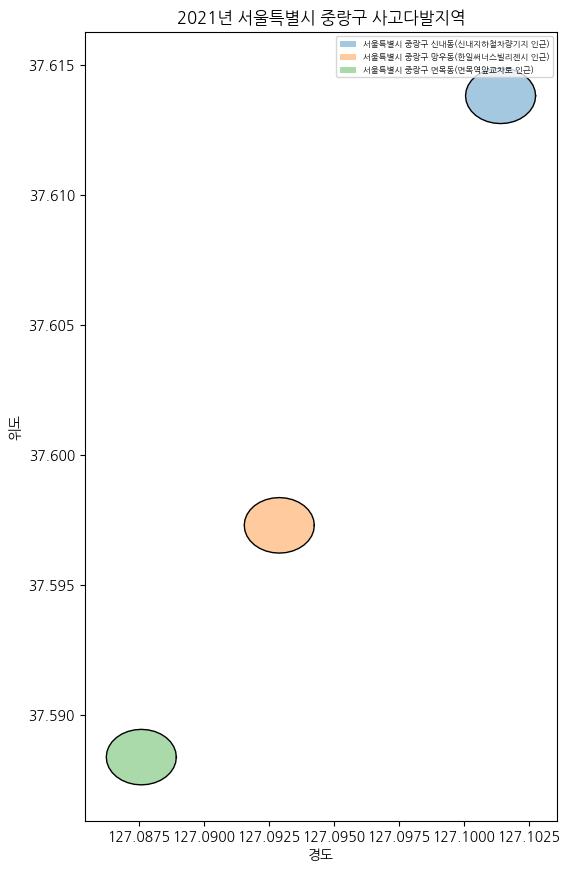

In [11]:
# 6) 2021년 서울특별시 중랑구 사고다발지역 이미지 (1024 x 1024) 생성 및 저장
import json
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = "NanumGothic"
mpl.rcParams["axes.unicode_minus"] = False

jungnang_path = ASSET_DIR / "2021_seoul_jungnang.json"
with jungnang_path.open(encoding="utf-8") as f:
    jungnang_data = json.load(f)

items = jungnang_data["items"]["item"]


fig, ax = plt.subplots(figsize=(10.24, 10.24), dpi=100)  

for item in items:
    geom = json.loads(item["geom_json"])  
    coords = geom["coordinates"][0]       
    xs = [p[0] for p in coords]           
    ys = [p[1] for p in coords]           

    ax.fill(xs, ys, alpha=0.4, label=item["spot_nm"]) 
    ax.plot(xs, ys, color="black", linewidth=1)       

ax.set_aspect("equal", "box")
ax.set_xlabel("경도")
ax.set_ylabel("위도")
ax.set_title("2021년 서울특별시 중랑구 사고다발지역")
ax.legend(fontsize=6, loc="upper right")

out_img_path = ASSET_DIR / "2021_seoul_jungnang.png"
plt.savefig(out_img_path, dpi=100, bbox_inches="tight")
plt.show()
plt.close(fig)
plt.show()


In [25]:
import requests
import json
url = "http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg"
params = {
  "ServiceKey" : "c386fa19f5ffc8fd2ba488e31eb8faf60ad4cff30335e720fb0e4b12db95f614",
  "searchYearCd" : "2017",
  "siDo" : "41",
  "guGun" : "390",
  "numOfRows" : "100",
  "pageNo" : "1",
  "type" : "json"
}
response = requests.get(url, params=params)
sh_list = json.loads(response.text)
sh_list['items']['item'][0]['spot_nm']
n = (len(sh_list['items']['item'][0]))
n
# n = len(sh_list['items']['item'])
# spot_list = []
# for i in range(n):
#     temp = sh_list['items']['item'][i]['spot_nm']
#     spot_list.append(temp)
    
# print(spot_list)


15

In [ ]:

import requests
import json
url = "http://apis.data.go.kr/B552061/frequentzoneLg/getRestFrequentzoneLg"
params = {
  "ServiceKey" : "c386fa19f5ffc8fd2ba488e31eb8faf60ad4cff30335e720fb0e4b12db95f614",
  "searchYearCd" : "2017",
  "siDo" : "41",
  "guGun" : "390",
  "numOfRows" : "100",
  "pageNo" : "1",
  "type" : "json"
}
response = requests.get(url, params=params)
# print(response.url)
# print(response.status_code)
# print(response.text)
sh_list = json.loads(response.text)
print(sh_list)
#sh_list['items']['item'][0]['spot_nm']
n = len(sh_list['items']['item'])
spot_list = []
for i in range(n):
    temp = sh_list['items']['item'][i]['spot_nm']
    spot_list.append(temp)
    
print(spot_list)

{'resultCode': '00', 'resultMsg': 'NORMAL_CODE', 'items': {'item': [{'afos_fid': 6467575, 'afos_id': '2018074', 'bjd_cd': '4139013200', 'spot_cd': '41390001', 'sido_sgg_nm': '경기도 시흥시1', 'spot_nm': '경기도 시흥시 정왕동(이마트사거리 인근)', 'occrrnc_cnt': 29, 'caslt_cnt': 44, 'dth_dnv_cnt': 0, 'se_dnv_cnt': 11, 'sl_dnv_cnt': 29, 'wnd_dnv_cnt': 4, 'geom_json': '{"type":"Polygon","coordinates":[[[126.73765839,37.34689474],[126.7376325,37.34668576],[126.73755582,37.34648481],[126.7374313,37.34629961],[126.73726373,37.34613728],[126.73705954,37.34600406],[126.73682658,37.34590507],[126.7365738,37.34584411],[126.73631092,37.34582353],[126.73604804,37.34584411],[126.73579526,37.34590507],[126.7355623,37.34600406],[126.73535811,37.34613728],[126.73519054,37.34629961],[126.73506602,37.34648481],[126.73498934,37.34668576],[126.73496345,37.34689474],[126.73498934,37.34710373],[126.73506602,37.34730468],[126.73519054,37.34748987],[126.73535811,37.3476522],[126.7355623,37.34778542],[126.73579526,37.34788441],[126.7